In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

import yaml
import pandas as pd
from sklearn.model_selection import train_test_split

from src.data.prepare_data import prepare_data
from src.models.utils import train_splits
from src.models.tuner import ClassifierThreshold
from src.models.model import Classifier
from src.visuals.pr_roc_curve import plot_roc_pr_curves
from src.models.evaluator import Evaluation

In [2]:
# read config
with open("../"+"config.yml", "r") as file:
    config=yaml.load(file, Loader= yaml.SafeLoader)
del file

In [3]:
# load and prepare data
df = pd.read_csv("../"+config["data_loader"]["path"])
df = prepare_data(df=df)
display(df.head())

# check class distributions
df["label"].value_counts(normalize=True)

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,-1.996580,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996580,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342474,0
2,-1.996558,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160684,0
3,-1.996558,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996537,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


label
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [4]:
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["label"]), df["label"]
    , test_size=config["train_test_split"]["test_size"]
    , random_state=42
    , shuffle=True
    , stratify=df["label"]
    )

# check class distributions
print(
    y_train.value_counts(normalize=True)
    , y_test.value_counts(normalize=True)
    )

label
0    0.998274
1    0.001726
Name: proportion, dtype: float64 label
0    0.998245
1    0.001755
Name: proportion, dtype: float64


In [5]:
# split train sets into multiple sets and check class distributions
train = train_splits(X_train, y_train, config["train_test_split"])
[train[i]["label"].value_counts(normalize=True) for i in train.keys()]

[label
 0    0.99827
 1    0.00173
 Name: proportion, dtype: float64,
 label
 0    0.998278
 1    0.001722
 Name: proportion, dtype: float64]

Ideal threshold value: 0.11324185878038406


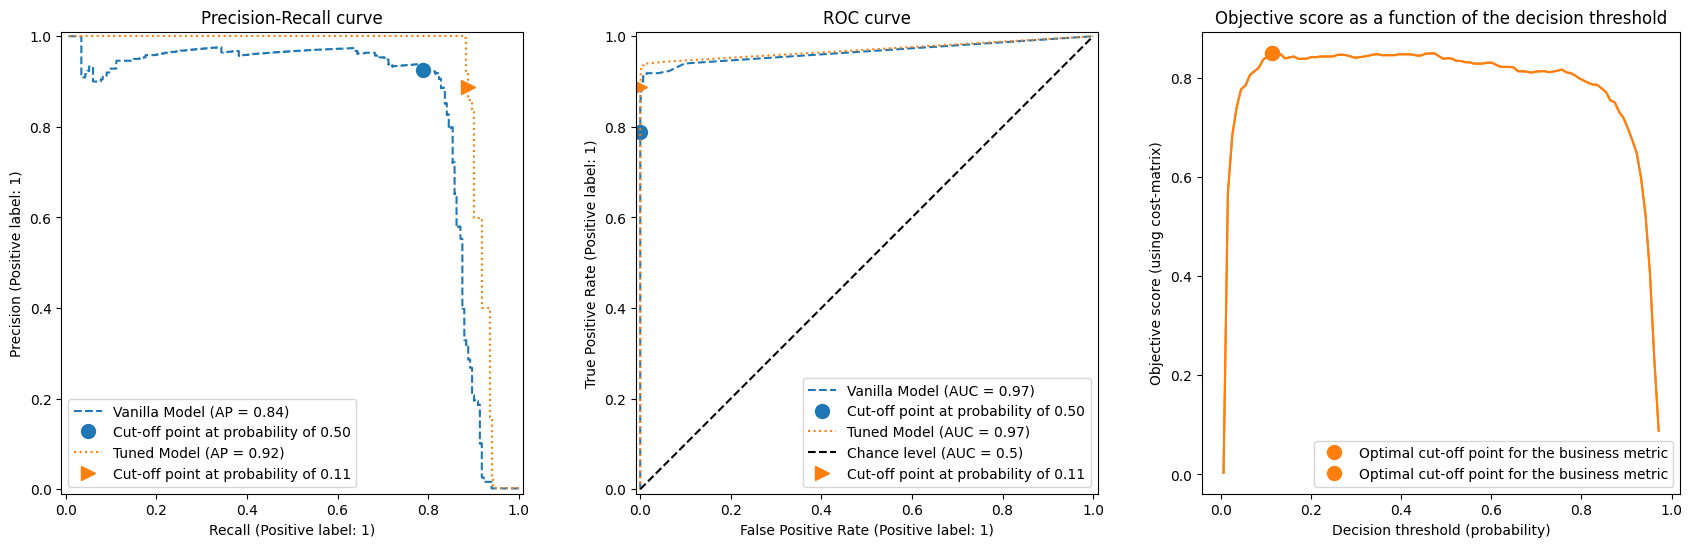

In [6]:
# fit algorithm
clf = Classifier(
    algorithm="XGBClassifier"
    , **{"n_estimators": 10, "max_depth": 20}
    )

clf.fit(X=train[1].drop(columns=["label"]), y=train[1]["label"])

# tune classification threshold
tuned_clf = ClassifierThreshold(config=config["optimization"])
tuned_clf.fit(clf=clf, X_train=train[2].drop(columns=["label"]), y_train=train[2]["label"])

threshold = tuned_clf.best_threshold
print(f"Ideal threshold value: {threshold}")

plot_roc_pr_curves(clf.model, tuned_clf.model, X_train=train[2].drop(columns=["label"]), y_train=train[2]["label"])

In [7]:
# fit algorithm on whole training set
clf = Classifier(
    algorithm="XGBClassifier"
    , **{"n_estimators": 10, "max_depth": 20}
    )
clf.fit(X=X_train, y=y_train)

# test set evaluation
for i in [0.5, threshold]:
    eval = Evaluation(clf=clf, threshold=i)
    display(
        eval.fit(
            train=(X_train, y_train),
            test=(X_test, y_test)
            )
            )

,accuracy,precision,recall,f1,roc_auc
dataset,,,,,
train,0.999756,0.997519,0.860814,0.924138,0.975681
test,0.999579,1.000000,0.760000,0.863636,0.955110


,accuracy,precision,recall,f1,roc_auc
dataset,,,,,
train,0.999653,0.913525,0.882227,0.897603,0.975681
test,0.999298,0.777778,0.840000,0.807692,0.955110
